In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

## Обработка данных

In [2]:
data = pd.read_csv('train.csv')

In [30]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
#Разделяем на тренировочные и тестовые данные

data_train, data_test, y_train, y_test = train_test_split(data.drop(columns='SalePrice'), data['SalePrice'], test_size=0.30, random_state=42)

In [4]:
#Находим категориальные признаки

categorials = list(data.dtypes[data.dtypes == object].index)

categorials_nunique = data_train[categorials].nunique()

#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
data[categorials] = data[categorials].fillna('nan')

In [5]:
#отфильтруем непрерывные признаки
integer = [f for f in data if f not in (categorials + ['ID', 'SalePrice'])]

In [6]:
# Создаем дамми-переменные для категорий
dummy_train = pd.get_dummies(data_train[categorials], columns=categorials)
dummy_test = pd.get_dummies(data_test[categorials], columns=categorials)

dummy_cols = list(set(dummy_train) & set(dummy_test))

dummy_train = dummy_train[dummy_cols]
dummy_test = dummy_test[dummy_cols]

# Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
X_train = pd.concat([data_train[integer].fillna(-999), dummy_train], axis=1)

X_test = pd.concat([data_test[integer].fillna(-999), dummy_test], axis=1)

## Случайный лес

In [7]:
# Создаем модель RandomForest
clf_rf = RandomForestRegressor()
clf_rf.fit(X_train, y_train)

RandomForestRegressor()

In [8]:
# проверяем полученные данные на тренировочных данных

clf_rf.score(X_train, y_train)

0.9757176813878152

In [9]:
# проверяем полученные данные на тестовых данных

clf_rf.score(X_test, y_test)

#Модель получилась не много переобученной

0.8899565697461044

In [38]:
# Выявляем наиболее важные признаки и выводим на график. Большое значение имеет признак Overall Qual, остальные почти равны нулю

imp = pd.Series(clf_rf.feature_importances_)
imp.index = pd.Series(X_train.columns)

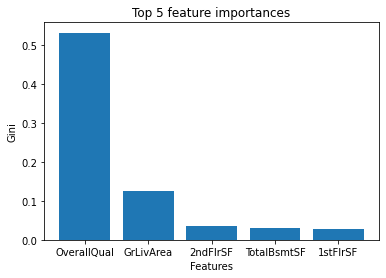

In [39]:
plt.title('Top 5 feature importances')
plt.xlabel('Features')
plt.ylabel('Gini')
plt.bar(imp.sort_values(ascending=False).head().index, imp.sort_values(ascending=False).head())
plt.show()

## Стекинг

In [40]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import RidgeCV

In [41]:
# Создаем стэккинг и обучаем его на наших данных

Regressor = StackingRegressor(
    [
        ('LinearRegression', LinearRegression()),
        ('KNeighborsRegressor', KNeighborsRegressor()),
        ('DecisionTree', DecisionTreeRegressor())
    ], RidgeCV())

In [42]:
Regressor.fit(X_train, y_train)

StackingRegressor(estimators=[('LinearRegression', LinearRegression()),
                              ('KNeighborsRegressor', KNeighborsRegressor()),
                              ('DecisionTree', DecisionTreeRegressor())],
                  final_estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ])))

In [43]:
print(f'Score on train data {Regressor.score(X_train, y_train)}')
print(f'Score on test data {Regressor.score(X_test, y_test)}')

for i in Regressor.named_estimators:
    print(f'Score on train data with model {i} {Regressor.named_estimators_[i].score(X_train, y_train)}')
    print(f'Score on test data with model {i} {Regressor.named_estimators_[i].score(X_test, y_test)}')

Score on train data 0.9566728335914221
Score on test data 0.8580514066341567
Score on train data with model LinearRegression 0.922108540356243
Score on test data with model LinearRegression 0.8533836050579262
Score on train data with model KNeighborsRegressor 0.7419951520813983
Score on test data with model KNeighborsRegressor 0.6775304068635524
Score on train data with model DecisionTree 1.0
Score on test data with model DecisionTree 0.7289173541695342


In [44]:
score_train = {}
score_test = {}

for i in Regressor.named_estimators:
    score_train[i] = Regressor.named_estimators_[i].score(X_train, y_train)
    score_test[i] = Regressor.named_estimators_[i].score(X_test, y_test)

score_train['Total']= Regressor.score(X_train, y_train)
score_test['Total']= Regressor.score(X_test, y_test)

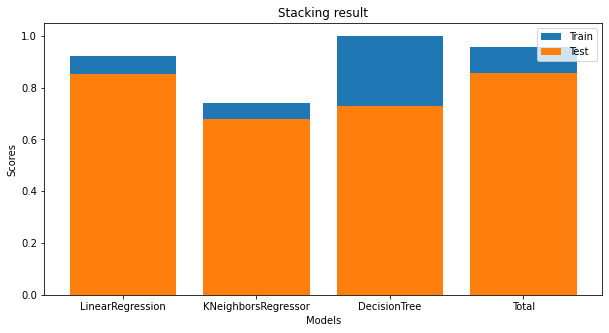

In [45]:
plt.figure(figsize=(10,5))
plt.bar(range(len(score_train)), score_train.values(), align="center", label='Train')
plt.xticks(range(len(score_train)), list(score_train.keys()))
plt.bar(range(len(score_test)), score_test.values(), align="center", label='Test')
plt.xticks(range(len(score_test)), list(score_test.keys()))
plt.autoscale
plt.title('Stacking result')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.legend()